# DATA 612 Project 3 - Matrix Factorization

By Mike Silva

## Introduction

This is an implementation of a matrix factorization method in the context of a recommender system.  

### About the MovieLens Dataset

For this project I will be using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/).  The MovieLens datasets were collected by GroupLens Research at the University of Minnesota.  This particular data set has 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.  It is the data set the GroupLens group recommends for research and education.  It is not a static data set.  The data I will be using was last updated in September of 2018.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import requests
import zipfile
from scipy.sparse.linalg import svds

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("ml-latest-small.zip"):
    # We need to download it
    response = requests.get("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
    if response.status_code == 200:
        with open("ml-latest-small.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT THE DATA SET
if not os.path.exists("ratings.csv"):
    with zipfile.ZipFile("ml-latest-small.zip","r") as z:
        z.extractall()
# STEP 3 - READ ING THE DATA
ratings = pd.read_csv("ml-latest-small/ratings.csv") 
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Since we have a time stamp we are going to use it to split the data into training and test sets.  We will use the latest ratings as the test set.  We will use and 80/20 split.

In [2]:
def train_test_split(df, test_proportion = .2):
    test_length = int(len(df) * test_proportion)
    train_length = len(df) - test_length
    test_df = df.tail(test_length)
    train_df = df.head(train_length)
    return (train_df, test_df)
    
ratings = ratings.sort_values(by=['timestamp']).reset_index(drop=False)
ratings_train, ratings_test = train_test_split(ratings)

In [3]:
A = ratings_train.pivot(index="userId", columns="movieId", values="rating").fillna(0)
A

movieId,1,2,3,4,5,6,7,8,9,10,...,146028,146210,146656,148424,148626,148675,149380,150548,152711,155168
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have the training dataset prepared we can start making SVD predictions.  This function allows the user to adjust the number of singular values to keep so they can control how the dimensionality reduction factor.  It also give the option to adjust for the user's rating bias.

In [4]:
def get_svd_predictions(A, k, adjust_for_user_bias = False):
    """Get ratings predictions using SVD.
        Args:
    A (DataFrame): The user item rating matrix
    k (int): The number of singular values
    adjust_for_user_bias (bool): Should A be adjusted by the user mean? (Optional: False default)
        Returns:
    predictions (DataFrame): Predicted user item rating matrix
    """
    # Check if we need to remove the user bias
    if adjust_for_user_bias:
        user_ratings_mean = np.mean(A.values, axis=1)
        A = A - user_ratings_mean.reshape(-1, 1)
    # Do the SVD decomposition
    U, sigma, Vt = svds(A, k=k)
    sigma = np.diag(sigma)
    # Build the prediction matrix
    predictions = np.dot(np.dot(U, sigma), Vt)
    # Check if we need to add back in the user bias
    if adjust_for_user_bias:
        predictions = predictions + user_ratings_mean.reshape(-1, 1)
    # Let's round it to the nearest half
    predictions = np.matrix.round(predictions * 2, 0) / 2
    # Make sure values are between 0 and 5
    predictions[predictions < 0] = 0
    predictions[predictions > 5] = 5
    # Return the predictions
    predictions = pd.DataFrame(predictions, index=A.index, columns=A.columns)
    return predictions

svd_predictions = get_svd_predictions(A, 100)
svd_predictions

movieId,1,2,3,4,5,6,7,8,9,10,...,146028,146210,146656,148424,148626,148675,149380,150548,152711,155168
userId,,,,,,,,,,,,,,,,,,,,,
1,3.5,-0.0,4.0,0.0,-0.0,3.5,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
4,0.0,-0.0,0.5,0.0,0.0,0.5,1.0,0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
5,2.5,1.0,-0.0,0.0,0.0,0.5,0.5,0.0,-0.0,1.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,5.0,2.5,0.0,-0.0,0.5,0.0,0.0,-0.0,0.0,-0.0,...,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
606,2.5,-0.0,0.0,0.0,-0.0,-0.0,2.5,0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
607,4.5,-0.0,0.5,0.0,0.0,0.5,-0.0,0.0,0.5,0.0,...,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0


Now that I can produce predictions I need to evaluate them against the test set and tune the k parameter to minimize the error.  I also need to implement a item to item collaborative filter to compare the accuracy of the approach. 

In [5]:
average_rating = round(ratings_test['rating'].mean() * 2) / 2

def get_svd_RMSE(predictions, ratings_test, average_rating):
    """Get the RMSE for a set of test data based off of predictions.
    Args:
        predictions (DataFrame): user to items rating prediction matrix
        ratings_test (DataFrame): Test set of ratings
        average_rating (float): Rating to substitute in when no ratings are available
    Returns:
        RMSE (float): The RMSE for the test set
    """
    predictions_long = pd.melt(predictions.reset_index(), id_vars=['userId'], var_name='movieId', value_name='yhat_rating')
    eval_df = pd.merge(ratings_test, predictions_long, how="left").fillna(average_rating)
    eval_df['error'] = eval_df['yhat_rating'] - eval_df['rating']
    eval_df['squared_error'] = eval_df['error'] ** 2
    mean_squared_error = eval_df['squared_error'].mean()
    RMSE = mean_squared_error ** (1/2)
    return RMSE

get_svd_RMSE(svd_predictions, ratings_test, average_rating)

1.3775268437623505

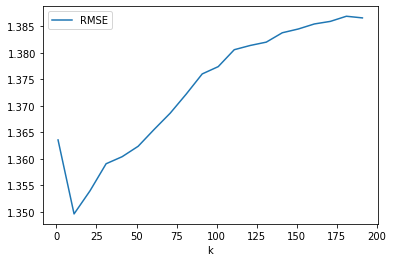

In [6]:
RMSEs = []
for k in range(1, 200, 10):
    svd_predictions = get_svd_predictions(A, k)
    RMSE = get_svd_RMSE(svd_predictions, ratings_test, average_rating)
    RMSEs.append({'k':k, 'RMSE':RMSE})

RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')

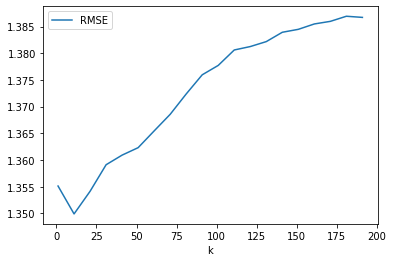

In [7]:
RMSEs = []
for k in range(1, 200, 10):
    svd_predictions = get_svd_predictions(A, k, True)
    RMSE = get_svd_RMSE(svd_predictions, ratings_test, average_rating)
    RMSEs.append({'k':k, 'RMSE':RMSE})

RMSEs = pd.DataFrame(RMSEs)
RMSEs.plot(x='k', y='RMSE')